## Importing detectron2 and DensePose

In [31]:
# install dependencies
!pip install -U torch torchvision cython matplotlib opencv-python numpy scipy tqdm
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvisio

torch.__version__

!git clone https://github.com/facebookresearch/detectron2
!pip install -e detectron2

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

from typing import ClassVar, Dict

from detectron2.config import get_cfg
from detectron2.structures.instances import Instances
from detectron2.engine.defaults import DefaultPredictor

from densepose import add_densepose_config
from densepose.vis.base import CompoundVisualizer
from densepose.vis.bounding_box import ScoredBoundingBoxVisualizer
from densepose.vis.extractor import CompoundExtractor, create_extractor

from densepose.structures import  DensePoseResult

from densepose.vis.densepose import (
    DensePoseResultsContourVisualizer,
    DensePoseResultsFineSegmentationVisualizer,
    DensePoseResultsUVisualizer,
    DensePoseResultsVVisualizer,
)

## Configuring the model

In [2]:
cfg = get_cfg()
add_densepose_config(cfg)

cfg.merge_from_file('configs/densepose_rcnn_R_50_FPN_s1x.yaml')
cfg.MODEL.DEVICE = 'cuda'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.MODEL.WEIGHTS = 'densepose_rcnn_R_50_FPN_s1x.pkl'

Config 'configs/densepose_rcnn_R_50_FPN_s1x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


## Creating the predictor

In [3]:
predictor = DefaultPredictor(cfg)

## Visualizers

In [4]:
VISUALIZERS: ClassVar[Dict[str, object]] = {
    'dp_contour': DensePoseResultsContourVisualizer,
    'dp_segm': DensePoseResultsFineSegmentationVisualizer,
    'dp_u': DensePoseResultsUVisualizer,
    'dp_v': DensePoseResultsVVisualizer,
    'astype': ScoredBoundingBoxVisualizer,
}

## Predict method

In [9]:
def predict(img, ext, vis=None):
    img_copy = img.copy()
    instances = predictor(img_copy)['instances'] #Q: Explain that
#     print(instances)

    densepose_result = ext(instances)
#     print('densepose_result: ', densepose_result)
#     print('densepose_result[0]: ', densepose_result[0])
    
    image_vis = None
    for i, result_encoded_w_shape in enumerate(densepose_result.results):
        if i != 0:
            continue
        IUV = DensePoseResult.decode_png_data(*result_encoded_w_shape)
        bbox = densepose_result.boxes_xywh[i]
    if vis:
        image_vis = vis.visualize(img_copy, densepose_result)
        plt.figure(figsize=(20,10))
        plt.imshow(image_vis)
    return (bbox, IUV, image_vis)

densepose_result:
iuv_arr:
    i: body part index
    u: u coodinates
    v: v coodinates
bbox: bound box with person

## Predicting image

bbox: [353.5853576660156, 422.2627868652344, 595.9989013671875, 1481.4691162109375]
IUV.shape: (3, 1481, 595)


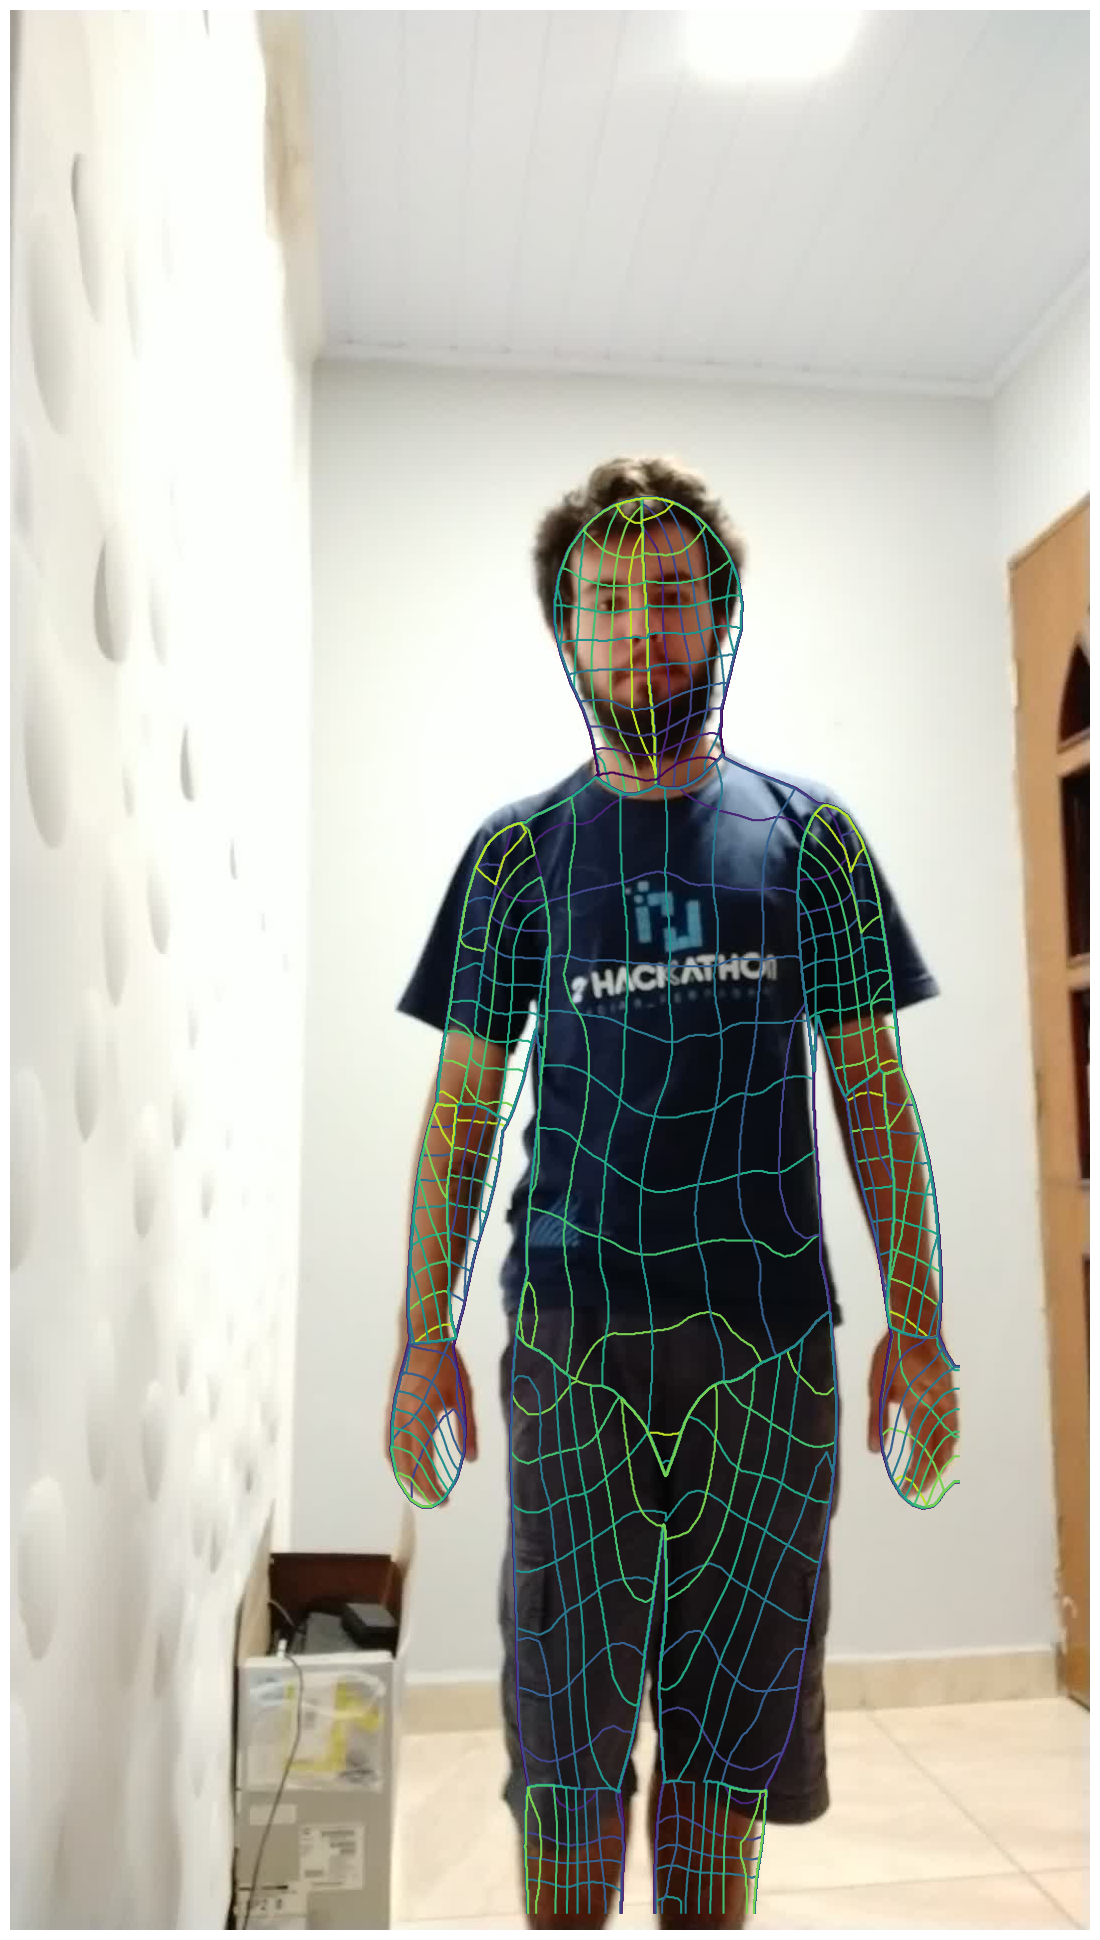

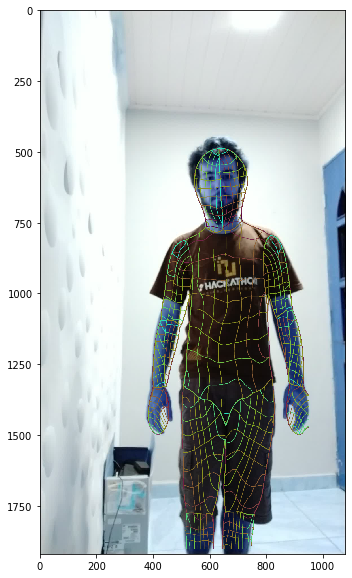

In [11]:
%matplotlib inline

visualizers = [
    VISUALIZERS['dp_segm'](),
    VISUALIZERS['dp_contour'](),
    VISUALIZERS['dp_u'](),
    VISUALIZERS['dp_v']()
]

vs = visualizers[1]
ext = create_extractor(vs)

im = cv2.imread('video.jpeg')
(bbox, IUV, image_vis) = predict(im, ext, vs)

print('bbox:', bbox)
print('IUV.shape:', IUV.shape)

## Croppping image

In [12]:
x, y, w, h = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
print('x y w h:', x, y, w, h)

crop_img = im[y:y+h, x:x+w]
print('crop img shape:', crop_img.shape)

x y w h: 353 422 595 1481
crop img shape: (1481, 595, 3)


## IUV

In [13]:
def plot_uv(im, IUV):
    fig = plt.figure(figsize=[12,12])
    plt.imshow( im[:,:,::-1] )
    plt.contour( IUV[0,:,:]/256.,10, linewidths = 1 )
    plt.contour( IUV[1,:,:]/256.,10, linewidths = 1 )
    plt.contour( IUV[2,:,:]/256.,10, linewidths = 1 )

def plot_countour(im, mask):
    fig = plt.figure(figsize=[12,12])
    plt.imshow( im[:,:,::-1] )
    plt.contour( mask/256.,10, linewidths = 1)
    
def plot(im):
    fig = plt.figure(figsize=[12,12])
    plt.imshow(im)

In [14]:
print(IUV.shape)
print(crop_img.shape)

(3, 1481, 595)
(1481, 595, 3)


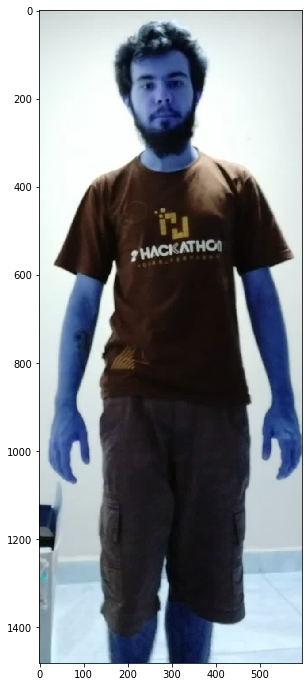

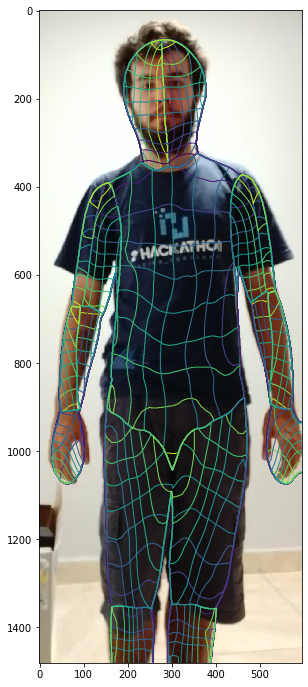

In [15]:
plot(crop_img)
plot_uv(crop_img, IUV)

## Masking body parts

1, 2 = Torso, 3 = Right Hand, 4 = Left Hand, 5 = Left Foot, 6 = Right Foot, 7, 9 = Upper Leg Right, 8, 10 = Upper Leg Left, 11, 13 = Lower Leg Right, 12, 14 = Lower Leg Left, 15, 17 = Upper Arm Left, 16, 18 = Upper Arm Right, 19, 21 = Lower Arm Left, 20, 22 = Lower Arm Right, 23, 24 = Head;

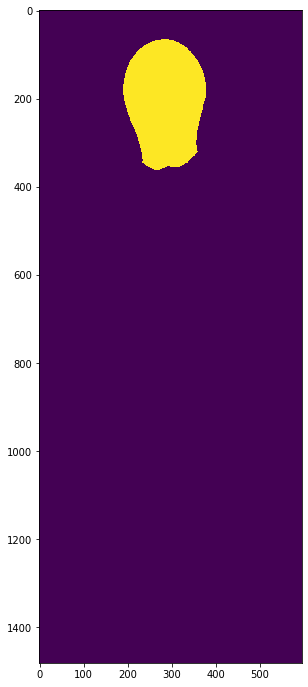

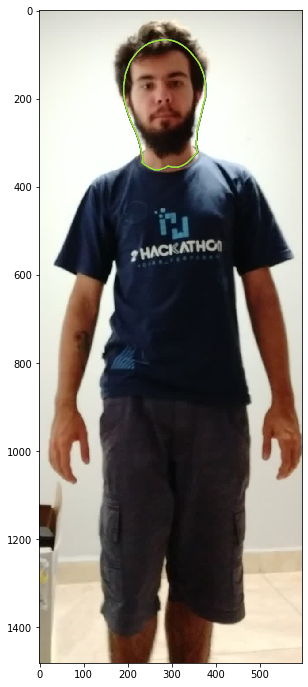

In [18]:
# Extracting heads
head_mask = (IUV[0] == 23) + (IUV[0] == 24)
plot(head_mask)
plot_countour(crop_img, head_mask)

In [19]:
# def iuvArr2IUV(iuv_arr):
#     iuv0 = iuv_arr[0,:,:]
#     iuv1 = iuv_arr[1,:,:]
#     iuv2 = iuv_arr[2,:,:]

#     return np.concatenate((iuv0[:,:,np.newaxis], iuv1[:,:,np.newaxis], iuv2[:,:,np.newaxis]), axis=2)

In [20]:
# IUV = iuvArr2IUV(iuv_arr)

## Drawing bbox around mask

In [21]:
def mask2bbox(mask):
    xs = np.where(np.sum(mask, axis=0) > 0)[0]
    ys = np.where(np.sum(mask, axis=1) > 0)[0]

    if len(xs) == 0 or len(ys) == 0:
        return None

    x0 = xs[0]
    x1 = xs[-1]

    y0 = ys[0]
    y1 = ys[-1]

    return np.array([x0, y0, x1, y1], dtype=np.float32)

In [22]:
def draw_bbox(im, bbox):
    img = cv2.rectangle(im,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(0,255,0),10)
    plot(img)

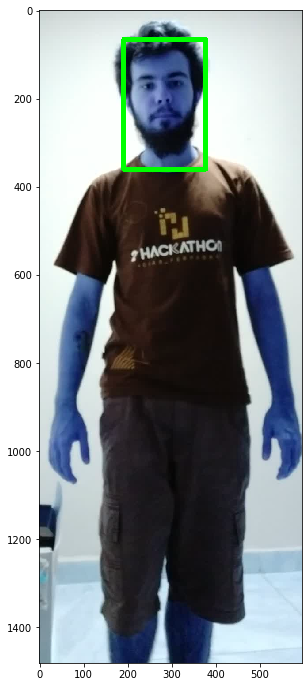

In [24]:
head_bbox = mask2bbox(head_mask)
draw_bbox(crop_img.copy(), head_bbox)

In [25]:
!pwd

/home/italojs/dev/python/densepose/detectron2/projects/DensePose


## DensePose1 to detectron2

In [26]:
import numpy as np
import copy
import cv2
from scipy.io  import loadmat
import scipy.spatial.distance
import os 

#original code: https://github.com/linjunyu/Detectron2-Densepose-IUV2XYZ

class DensePoseMethods:
    def __init__(self, uv_processed_mat_path, UV_symmetry_path):
        #
        ALP_UV = loadmat(uv_processed_mat_path) # Use your own path
        self.FaceIndices = np.array( ALP_UV['All_FaceIndices']).squeeze()
        self.FacesDensePose = ALP_UV['All_Faces']-1
        self.U_norm = ALP_UV['All_U_norm'].squeeze()
        self.V_norm = ALP_UV['All_V_norm'].squeeze()
        self.All_vertices =  ALP_UV['All_vertices'][0]
        ## Info to compute symmetries.
        self.SemanticMaskSymmetries = [0,1,3,2,5,4,7,6,9,8,11,10,13,12,14]
        self.Index_Symmetry_List = [1,2,4,3,6,5,8,7,10,9,12,11,14,13,16,15,18,17,20,19,22,21,24,23];
        self.UV_symmetry_transformations = loadmat(UV_symmetry_path)
    

    def get_symmetric_densepose(self,I,U,V,x,y,Mask):
        ### This is a function to get the mirror symmetric UV labels.
        Labels_sym= np.zeros(I.shape)
        U_sym= np.zeros(U.shape)
        V_sym= np.zeros(V.shape)
        ###
        for i in ( range(24)):
            if i+1 in I:
                Labels_sym[I == (i+1)] = self.Index_Symmetry_List[i]
                jj = np.where(I == (i+1))
                ###
                U_loc = (U[jj]*255).astype(np.int64)
                V_loc = (V[jj]*255).astype(np.int64)
                ###
                V_sym[jj] = self.UV_symmetry_transformations['V_transforms'][0,i][V_loc,U_loc]
                U_sym[jj] = self.UV_symmetry_transformations['U_transforms'][0,i][V_loc,U_loc]
        ##
        Mask_flip = np.fliplr(Mask)
        Mask_flipped = np.zeros(Mask.shape)
        #
        for i in ( range(14)):
            Mask_flipped[Mask_flip == (i+1)] = self.SemanticMaskSymmetries[i+1]
        #
        [y_max , x_max ] = Mask_flip.shape
        y_sym = y
        x_sym = x_max-x
        #
        return Labels_sym , U_sym , V_sym , x_sym , y_sym , Mask_flipped
    
    
    
    def barycentric_coordinates_exists(self,P0, P1, P2, P):
        u = P1 - P0
        v = P2 - P0
        w = P - P0
        #
        vCrossW = np.cross(v,w)
        vCrossU = np.cross(v, u)
        if (np.dot(vCrossW, vCrossU) < 0):
            return False;
        #
        uCrossW = np.cross(u, w)
        uCrossV = np.cross(u, v)
        #
        if (np.dot(uCrossW, uCrossV) < 0):
            return False;
        #
        denom = np.sqrt((uCrossV**2).sum())
        r = np.sqrt((vCrossW**2).sum())/denom
        t = np.sqrt((uCrossW**2).sum())/denom
        #
        return((r <=1) & (t <= 1) & (r + t <= 1))

    def barycentric_coordinates(self,P0, P1, P2, P):
        u = P1 - P0
        v = P2 - P0
        w = P - P0
        #
        vCrossW = np.cross(v,w)
        vCrossU = np.cross(v, u)
        #
        uCrossW = np.cross(u, w)
        uCrossV = np.cross(u, v)
        #
        denom = np.sqrt((uCrossV**2).sum())
        r = np.sqrt((vCrossW**2).sum())/denom
        t = np.sqrt((uCrossW**2).sum())/denom
        #
        return(1-(r+t),r,t)
    
    def barycentric_coordinates_fast(self, P0, P1, P2, P):
        # This is a merge of barycentric_coordinates_exists & barycentric_coordinates.
        # Inputs are (n, 3) shaped.

        u = P1 - P0   #u is (n,3)
        v = P2 - P0   #v is (n,3)
        w = P.T - P0    #w is (n,3)
        #
        vCrossW = np.cross(v, w) #result is (n,3)
        vCrossU = np.cross(v, u) #result is (n,3)
        A = np.einsum('nd,nd->n', vCrossW, vCrossU) # vector-wise dot product. Result shape is (n,)
        #
        uCrossW = np.cross(u, w)
        uCrossV = - vCrossU
        B = np.einsum('nd,nd->n', uCrossW, uCrossV)
        #
        sq_denoms = np.einsum('nd,nd->n', uCrossV, uCrossV) #result shape is  (n,)
        sq_rs = np.einsum('nd,nd->n', vCrossW, vCrossW)
        sq_ts = np.einsum('nd,nd->n', uCrossW, uCrossW)
        rs = np.sqrt(sq_rs / sq_denoms)  #result shape is  (n,)
        ts = np.sqrt(sq_ts / sq_denoms)
        #
        results = [None] * P0.shape[0]
        for i in range(len(results)):
            if not (A[i] < 0 or B[i] < 0):
                if ((rs[i] <= 1) and (ts[i] <= 1) and (rs[i] + ts[i] <= 1)):
                    results[i] = (1 - (rs[i] + ts[i]) , rs[i], ts[i])
        return results


    def IUV2FBC_fast( self, I_point , U_point, V_point):
        P = np.array([ U_point , V_point , 0 ])
        
        FaceIndicesNow  = np.where( self.FaceIndices == I_point )
        
        FacesNow = self.FacesDensePose[FaceIndicesNow]
        #
        P_0 = np.vstack( (self.U_norm[FacesNow][:,0], self.V_norm[FacesNow][:,0], np.zeros(self.U_norm[FacesNow][:,0].shape))).transpose()
        P_1 = np.vstack( (self.U_norm[FacesNow][:,1], self.V_norm[FacesNow][:,1], np.zeros(self.U_norm[FacesNow][:,1].shape))).transpose()
        P_2 = np.vstack( (self.U_norm[FacesNow][:,2], self.V_norm[FacesNow][:,2], np.zeros(self.U_norm[FacesNow][:,2].shape))).transpose()
        #
        bcs = self.barycentric_coordinates_fast(P_0, P_1, P_2, P)
        for i, bc in enumerate(bcs):
            if bc is not None:
                bc1,bc2,bc3 = bc
                return(FaceIndicesNow[0][i],bc1,bc2,bc3)
        #
        # If the found UV is not inside any faces, select the vertex that is closest!
        #
        D1 = scipy.spatial.distance.cdist( np.array( [U_point,V_point])[np.newaxis,:] , P_0[:,0:2]).squeeze()
        D2 = scipy.spatial.distance.cdist( np.array( [U_point,V_point])[np.newaxis,:] , P_1[:,0:2]).squeeze()
        D3 = scipy.spatial.distance.cdist( np.array( [U_point,V_point])[np.newaxis,:] , P_2[:,0:2]).squeeze()
        #
        minD1 = D1.min()
        minD2 = D2.min()
        minD3 = D3.min()
        #
        if((minD1< minD2) & (minD1< minD3)):
            return(  FaceIndicesNow[0][np.argmin(D1)] , 1.,0.,0. )
        elif((minD2< minD1) & (minD2< minD3)):
            return(  FaceIndicesNow[0][np.argmin(D2)] , 0.,1.,0. )
        else:
            return(  FaceIndicesNow[0][np.argmin(D3)] , 0.,0.,1. )


    def IUV2FBC( self, I_point , U_point, V_point):
        P = [ U_point , V_point , 0 ]
        FaceIndicesNow  = np.where( self.FaceIndices == I_point )
        FacesNow = self.FacesDensePose[FaceIndicesNow]
        #
        P_0 = np.vstack( (self.U_norm[FacesNow][:,0], self.V_norm[FacesNow][:,0], np.zeros(self.U_norm[FacesNow][:,0].shape))).transpose()
        P_1 = np.vstack( (self.U_norm[FacesNow][:,1], self.V_norm[FacesNow][:,1], np.zeros(self.U_norm[FacesNow][:,1].shape))).transpose()
        P_2 = np.vstack( (self.U_norm[FacesNow][:,2], self.V_norm[FacesNow][:,2], np.zeros(self.U_norm[FacesNow][:,2].shape))).transpose()
        #

        for i, [P0,P1,P2] in enumerate( zip(P_0,P_1,P_2)) :
            if(self.barycentric_coordinates_exists(P0, P1, P2, P)):
                [bc1,bc2,bc3] = self.barycentric_coordinates(P0, P1, P2, P)
                return(FaceIndicesNow[0][i],bc1,bc2,bc3)
        #
        # If the found UV is not inside any faces, select the vertex that is closest!
        #
        D1 = scipy.spatial.distance.cdist( np.array( [U_point,V_point])[np.newaxis,:] , P_0[:,0:2]).squeeze()
        D2 = scipy.spatial.distance.cdist( np.array( [U_point,V_point])[np.newaxis,:] , P_1[:,0:2]).squeeze()
        D3 = scipy.spatial.distance.cdist( np.array( [U_point,V_point])[np.newaxis,:] , P_2[:,0:2]).squeeze()
        #
        minD1 = D1.min()
        minD2 = D2.min()
        minD3 = D3.min()
        #
        if((minD1< minD2) & (minD1< minD3)):
            return(  FaceIndicesNow[0][np.argmin(D1)] , 1.,0.,0. )
        elif((minD2< minD1) & (minD2< minD3)):
            return(  FaceIndicesNow[0][np.argmin(D2)] , 0.,1.,0. )
        else:
            return(  FaceIndicesNow[0][np.argmin(D3)] , 0.,0.,1. )


    def FBC2PointOnSurface( self, FaceIndex, bc1,bc2,bc3,Vertices ):
        ##
        Vert_indices = self.All_vertices[self.FacesDensePose[FaceIndex]]-1
        ##
        p = Vertices[Vert_indices[0],:] * bc1 +  \
            Vertices[Vert_indices[1],:] * bc2 +  \
            Vertices[Vert_indices[2],:] * bc3 
        ##
        return(p)

print('done')

done


In [27]:
from mpl_toolkits.mplot3d import axes3d, Axes3D #Matplootlib
from tqdm import tqdm #progressbar
import time
import matplotlib.pyplot as plt
import pickle
import gzip

## SMPL - Skinned Multi-Person Linear Model    
SMPL is a realistic 3D model of the human body that is based on skinning and blend shapes and is learned from thousands of 3D body scans.
https://smpl.is.tue.mpg.de/

In [28]:
with open('./SMPL_python_v.1.0.0/smpl/models/basicmodel_m_lbs_10_207_0_v1.0.0.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    data = u.load()
    Vertices = data['v_template']  #(6890, 3)
    X,Y,Z = [Vertices[:,0], Vertices[:,1],Vertices[:,2]]

In [29]:
personId = 1

# Human coordinates
C = np.where(IUV[0,:,:] >= personId)
print(C)
print('num pts on picked person:', C[0].shape)

(array([  66,   66,   66, ..., 1480, 1480, 1480]), array([277, 278, 279, ..., 387, 388, 389]))
num pts on picked person: (445686,)


In [30]:
INDS =IUV[0,:,:]

In [59]:
IUV.shape

(3, 1481, 595)

In [60]:
def invertIUV(iuv_arr):
    iuv0 = iuv_arr[0,:,:]
    iuv1 = iuv_arr[1,:,:]
    iuv2 = iuv_arr[2,:,:]

    return np.concatenate((iuv0[:,:,np.newaxis], iuv1[:,:,np.newaxis], iuv2[:,:,np.newaxis]), axis=2)

IUV = invertIUV(IUV)

In [63]:
IUV.shape

(1481, 595, 3)

In [64]:
IUV_person = IUV[C[0], C[1], :] # boolean indexing
IUV_person = IUV_person.astype(np.float)
IUV_person[:, 1:3] = IUV_person[:, 1:3] / 255.0
print(IUV_person.shape)

(445686, 3)


In [65]:
collected_x = np.zeros(C[0].shape)
collected_y = np.zeros(C[0].shape)
collected_z = np.zeros(C[0].shape)

In [ ]:
DP = DensePoseMethods('./UV_Processed.mat', './UV_symmetry_transforms.mat')
pbar = tqdm(total=IUV_person.shape[0])
for i in range(IUV_person.shape[0]):
    pbar.update(1) # Use tqdm to visualize the converting process

    # Convert IUV to FBC (faceIndex and barycentric coordinates.)
    FaceIndex,bc1,bc2,bc3 = DP.IUV2FBC_fast(IUV_person[i, 0], IUV_person[i, 1], IUV_person[i, 2])
    # Use FBC to get 3D coordinates on the surface.
    p = DP.FBC2PointOnSurface(FaceIndex, bc1,bc2,bc3,Vertices)
    #
    collected_x[i] = p[0]
    collected_y[i] = p[1]
    collected_z[i] = p[2]

pbar.close()
print('IUV to PointOnSurface done')
IUV.shape: (750, 268, 3)

In [29]:
# Now read the smpl model.
with open('./SMPL_python_v.1.0.0/smpl/models/basicmodel_m_lbs_10_207_0_v1.0.0.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()
    data = p

    Vertices = data['v_template']  ##  Loaded vertices of size (6890, 3)
    X,Y,Z = [Vertices[:,0], Vertices[:,1],Vertices[:,2]]

# Color of each (U,V) point.
C = np.where(IUV[:,:,0] >= personId)
# C[0] is x-coords  np.array([23,  23,   24, ..])
# C[1] is y-coords  np.array([127, 128, 130, ..])
print('num pts on picked person:', C[0].shape)
person_color = crop_img[C[0], C[1], ::-1]  # boolean indexing.   ::-1 to make the RGB/BGR convention suitable for plotting.
print('person color shape:', person_color.shape)

num pts on picked person: (445686,)
person color shape: (445686, 3)


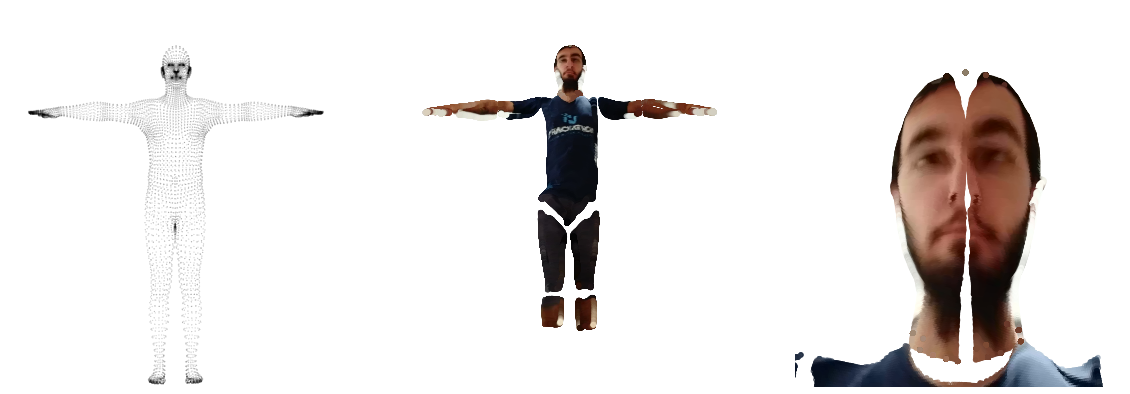

In [30]:
def smpl_view_set_axis_full_body(ax):
    ## Manually set axis
    ax.view_init(0, 0)
    max_range = 0.55
    ax.set_xlim(- max_range, max_range)
    ax.set_ylim(- max_range, max_range)
    ax.set_zlim(-0.2 - max_range, -0.2 + max_range)
    ax.axis('off')

def smpl_view_set_axis_face(ax):
    ## Manually set axis
    ax.view_init(0, 0)
    max_range = 0.1
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)
    ax.set_zlim(0.45 - max_range, 0.45 + max_range)
    ax.axis('off')

fig = plt.figure(figsize=[20,7])

## Visualize the full body smpl male template model and collected points
ax = fig.add_subplot(131, projection='3d')
ax.scatter(Z,X,Y,s=0.02,c='k')
smpl_view_set_axis_full_body(ax)

## Visualize the full body smpl male template model and collected points
ax = fig.add_subplot(132, projection='3d')
# ax.scatter(Z,X,Y,s=0.02,c='k')
ax.scatter(collected_z,  collected_x, collected_y,  c= person_color/255.0   )  #s=__ size
smpl_view_set_axis_full_body(ax)

## Now zoom into the face.
ax = fig.add_subplot(133, projection='3d')
# ax.scatter(Z,X,Y,s=0.2,c='k')
ax.scatter(collected_z,  collected_x, collected_y,c=person_color/255.0) #s=__ size
smpl_view_set_axis_face(ax)

plt.show()